In [1]:
import os
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import numpy as np

os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Using TensorFlow backend.


In [2]:
# 分類するクラス
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

nb_classes = len(classes)

img_width, img_height = 48, 48

# トレーニング用とバリデーション用の画像格納先
train_data_dir = './data/train'
validation_data_dir = './data/validation'


nb_train_samples = 700
nb_validation_samples = 210

batch_size = 32
nb_epoch = 60

In [3]:
def vgg_model_maker():
    """ VGG16のモデルをFC層以外使用。FC層のみ作成して結合して用意する """

    # VGG16のロード。FC層は不要なので include_top=False
    input_tensor = Input(shape=(img_width, img_height, 3))
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

    # FC層の作成
    top_model = Sequential()
    top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(nb_classes, activation='softmax'))

    # VGG16とFC層を結合してモデルを作成
    model = Model(inputs=vgg16.input, outputs=top_model(vgg16.output))

    return model

In [4]:
def image_generator():
    """ ディレクトリ内の画像を読み込んでトレーニングデータとバリデーションデータの作成 """
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        zoom_range=0.2,
        horizontal_flip=True)

    validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        color_mode='rgb',
        classes=classes,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True)

    validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        color_mode='rgb',
        classes=classes,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True)

    return (train_generator, validation_generator)

In [5]:
result_dir = 'trainingResult'
if not os.path.exists(result_dir):
    os.mkdir(result_dir)

In [6]:
# モデル作成
vgg_model = vgg_model_maker()

# 最後のconv層の直前までの層をfreeze
for layer in vgg_model.layers[:15]:
    layer.trainable = False

# 多クラス分類を指定
vgg_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
                metrics=['accuracy'])

# 画像のジェネレータ生成
train_generator, validation_generator = image_generator()

# Fine-tuning

history = vgg_model.fit_generator(
    train_generator,
    steps_per_epoch=int(nb_train_samples/batch_size),
    epochs=nb_epoch,
    validation_data=validation_generator,
    validation_steps=int(nb_validation_samples/batch_size)
)

vgg_model.save_weights(os.path.join(result_dir, 'finetuning-60.h5'))

Found 700 images belonging to 7 classes.
Found 210 images belonging to 7 classes.
Epoch 1/60
21/21 [==============================] - 40s 2s/step - loss: 1.9775 - accuracy: 0.1991 - val_loss: 2.0500 - val_accuracy: 0.1458
Epoch 2/60
21/21 [==============================] - 38s 2s/step - loss: 1.8201 - accuracy: 0.2710 - val_loss: 1.9172 - val_accuracy: 0.1798
Epoch 3/60
21/21 [==============================] - 38s 2s/step - loss: 1.7647 - accuracy: 0.2889 - val_loss: 2.0874 - val_accuracy: 0.2416
Epoch 4/60
21/21 [==============================] - 40s 2s/step - loss: 1.7017 - accuracy: 0.3383 - val_loss: 1.9478 - val_accuracy: 0.2022
Epoch 5/60
21/21 [==============================] - 41s 2s/step - loss: 1.6781 - accuracy: 0.3623 - val_loss: 2.3602 - val_accuracy: 0.2640
Epoch 6/60
21/21 [==============================] - 42s 2s/step - loss: 1.6601 - accuracy: 0.3548 - val_loss: 2.0182 - val_accuracy: 0.2809
Epoch 7/60
21/21 [==============================] - 42s 2s/step - loss: 1.6121

21/21 [==============================] - 41s 2s/step - loss: 0.2159 - accuracy: 0.9371 - val_loss: 4.7737 - val_accuracy: 0.4775
Epoch 59/60
21/21 [==============================] - 41s 2s/step - loss: 0.1659 - accuracy: 0.9521 - val_loss: 2.5894 - val_accuracy: 0.5056
Epoch 60/60
21/21 [==============================] - 40s 2s/step - loss: 0.1491 - accuracy: 0.9596 - val_loss: 2.4609 - val_accuracy: 0.4551


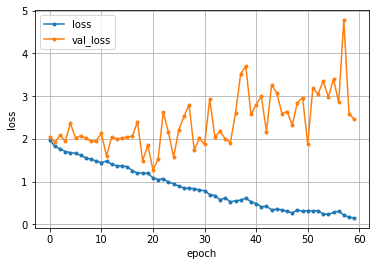

In [7]:
import matplotlib.pyplot as plt
loss     = history.history['loss']
val_loss = history.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss,     marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

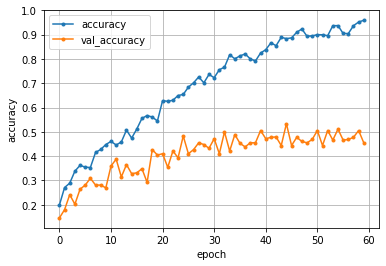

In [8]:
loss     = history.history['accuracy']
val_loss = history.history['val_accuracy']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss,     marker='.', label='accuracy')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_accuracy')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()